In [1]:
import matplotlib as plt
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
df = pd.read_csv('./data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df.loc[:,'treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [5]:
df = pd.get_dummies(df, columns=['zip_code', 'channel'], prefix=['zip_code', 'channel'])
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1


In [6]:
df['recency'] = StandardScaler().fit_transform(df['recency'].to_numpy().reshape(-1,1))
df['history'] = StandardScaler().fit_transform(df['history'].to_numpy().reshape(-1,1))
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,1.207751,-0.389003,1,0,0,1,0,0,1,0,0,1,0
1,0.067359,0.339614,1,1,1,0,0,1,0,0,0,0,1
2,0.352457,-0.239836,0,1,1,1,0,0,1,0,0,0,1
3,0.922653,1.693278,1,0,1,1,0,1,0,0,0,0,1
4,-1.073034,-0.768068,1,0,0,1,0,0,0,1,0,0,1


In [7]:
features = df.drop(columns=['target', 'treatment'])
target = df['target']

In [8]:
train, test = train_test_split(df.index, test_size=0.3, random_state=42)

X_train = features.loc[train, :]
y_train = df.loc[train, 'target']
treatment_train = df.loc[train, 'treatment']

X_val = features.loc[test, :]
y_val = df.loc[test, 'target']
treatment_val = df.loc[test, 'treatment']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

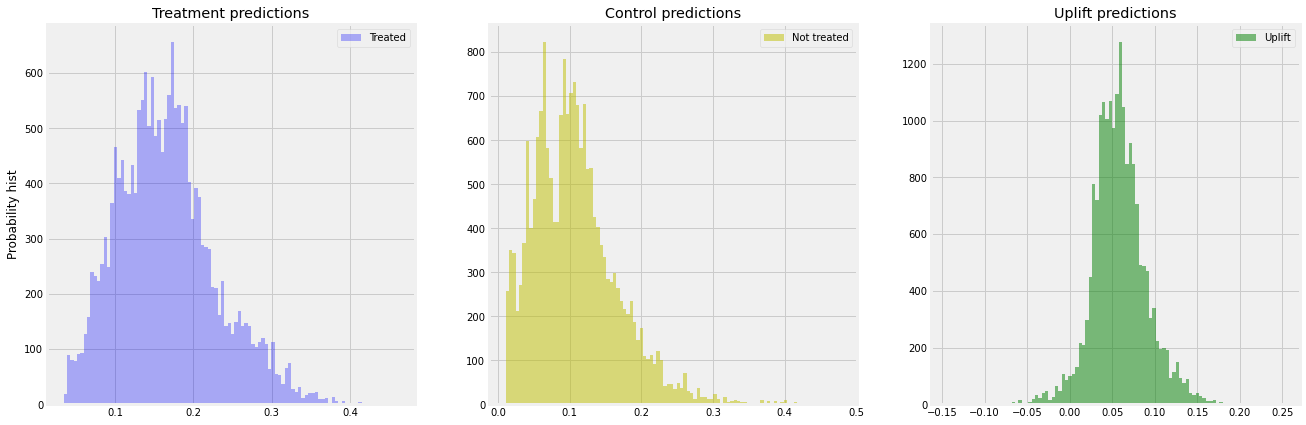

In [10]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=6, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treatment_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.3)


models_results['approach'].append('SoloModel_catboost')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

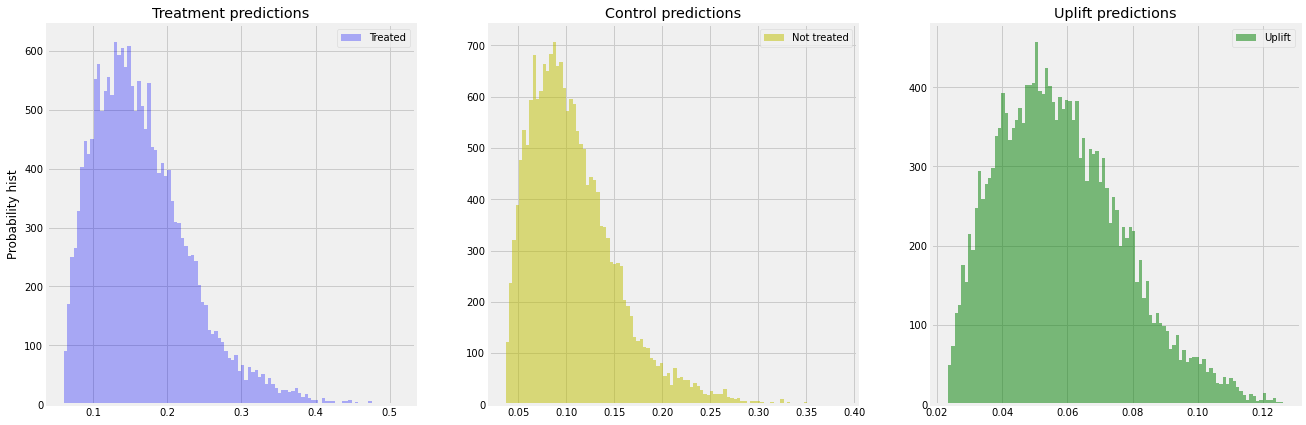

In [12]:
sm = SoloModel(LogisticRegression())
sm = sm.fit(X_train, y_train, treatment_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.3)


models_results['approach'].append('SoloModel_logreg')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


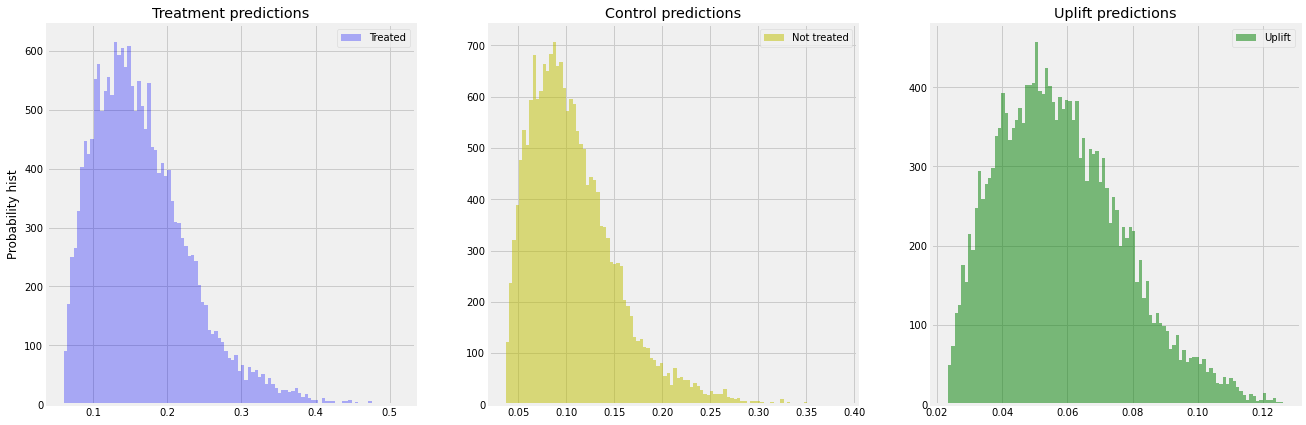

In [13]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=6, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treatment_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.3)


models_results['approach'].append('ClassTransformation_catbost')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


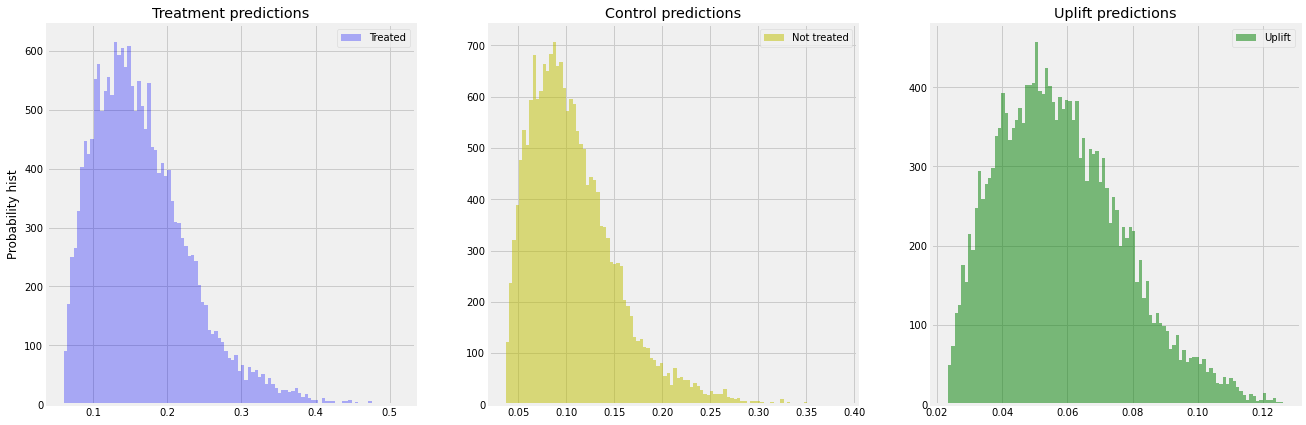

In [14]:
ct = ClassTransformation(LogisticRegression())
ct = ct.fit(X_train, y_train, treatment_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.3)


models_results['approach'].append('ClassTransformation_logreg')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

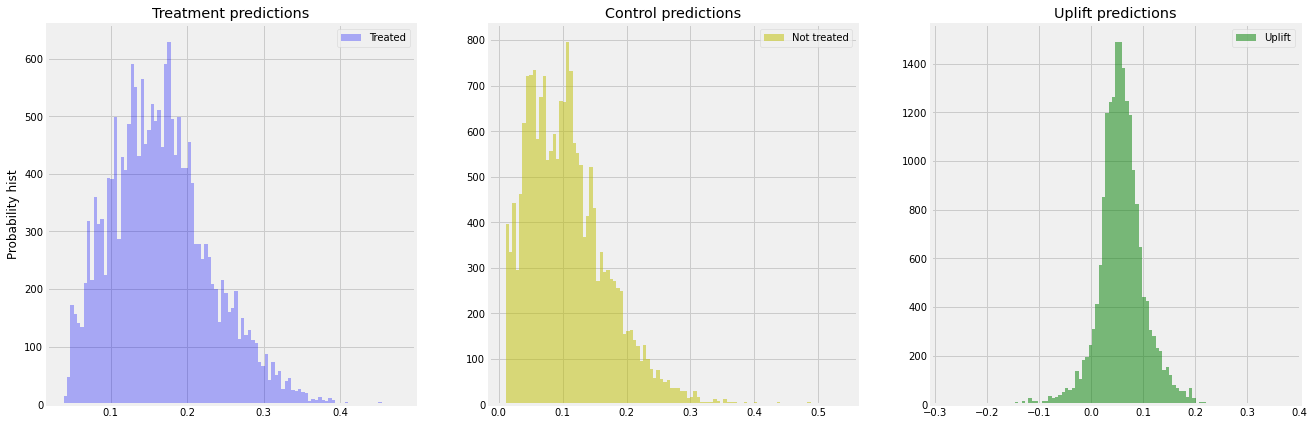

In [15]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treatment_train
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_catboost')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

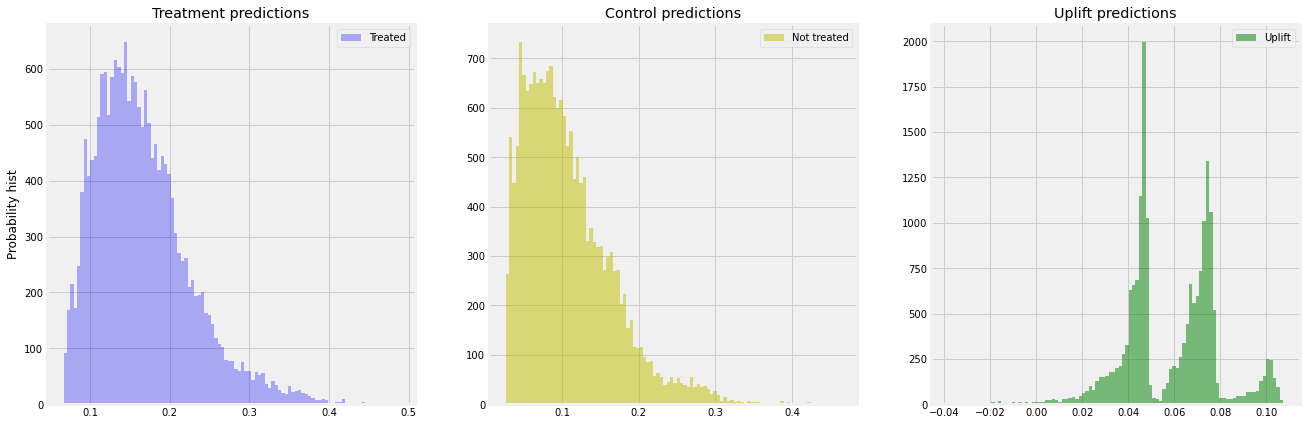

In [16]:
tm = TwoModels(
    estimator_trmnt=LogisticRegression(), 
    estimator_ctrl=LogisticRegression(), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treatment_train
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_catboost')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [17]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel_catboost,0.089963,0.078678,0.076440
1,SoloModel_catboost,0.089963,0.078678,0.076440
2,SoloModel_logreg,0.116104,0.099717,0.101193
3,ClassTransformation_catbost,0.108094,0.090923,0.078921
4,ClassTransformation_logreg,0.137222,0.107499,0.100654
5,TwoModels_catboost,0.081392,0.070171,0.075985
6,TwoModels_catboost,0.131612,0.110804,0.103837


In [29]:
df_for_tree = pd.read_csv('./data.csv')
treatment = df_for_tree['offer'].apply(lambda x: 0 if x == 'No Offer' else 1 )
df_for_tree = df_for_tree.drop(['offer', 'conversion'], 1)

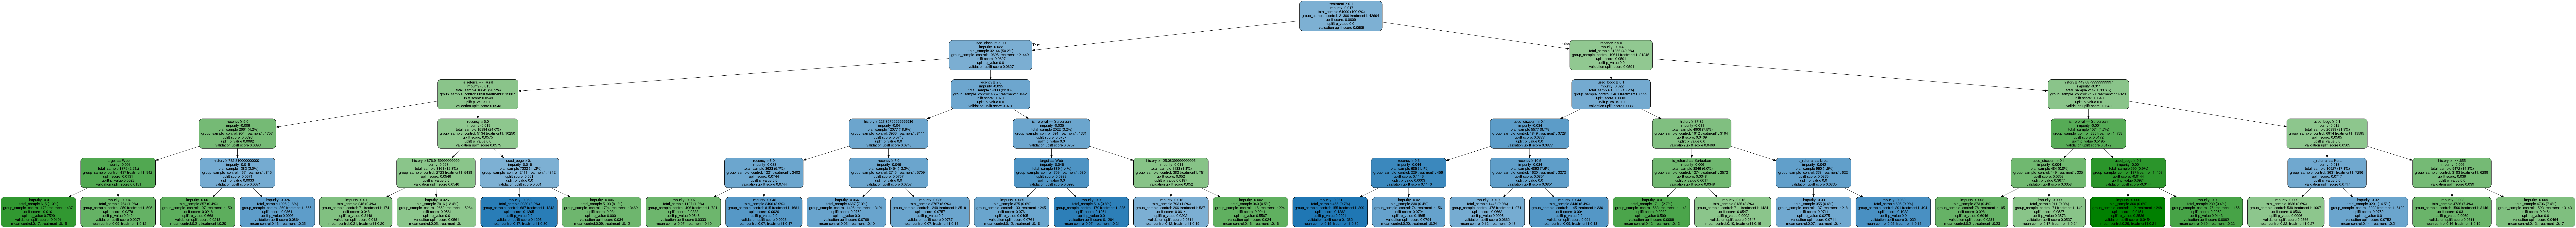

CPU times: user 9.84 s, sys: 12 ms, total: 9.86 s
Wall time: 10.7 s


In [30]:
%%time
features = [col for col in df]
uplift_model = UpliftTreeClassifier(max_depth=6, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_for_tree.values,
                 treatment=df['treatment'].map({1: 'treatment1', 0: 'control'}).values,
                 y=target)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

Привер описания листа:
1. Нужно звонить: Из реферального канала, использовал скидку, из сельской местности, сделал покупку менее 5 месяцев, потрил менее 732 долларов
2. Нужно звонить: Из реферального канала, использовал скидку, не из сельской местности покупал более 5 месяцев назад, потрил менее 877 долларов